In [477]:
import sys
sys.path.append('../')
from torchdyn.models import *

# Latent Neural ODEs

In [478]:
class HybridNeuralDE(nn.Module):
    def __init__(self, jump, flow, out, hidden_size, last_output=True, reverse=False):
        super().__init__()
        self.flow, self.jump, self.out = flow, jump, out
        self.hidden_size, self.last_output = hidden_size, last_output
        self.reverse = reverse
        
    def forward(self, x):
        h = self._init_latent(x[0])
        Y = []
        if self.reverse: x_t = x_t.flip(0)
        for i, x_t in enumerate(x): 
            h = self.jump(x_t, h)
            h = self.flow(h)
            Y.append(self.out(h)[None])
        Y = torch.cat(Y)
        return Y[-1] if self.last_output else Y
        
    def _init_latent(self, x):
        return torch.zeros((x.shape[0], self.hidden_size)).to(x.device)

In [479]:
def test_basic_hybrid_de():
    jump = nn.RNNCell(input_size=2, hidden_size=8)
    f = DEFunc(nn.Linear(8, 8))
    flow = NeuralDE(f, settings={})
    out = nn.Linear(8, 2)
    model = HybridNeuralDE(jump, flow, out, 8)
    x = torch.randn((100, 10, 2))
    out = model(x)
    assert out.shape == x[0].shape

def test_last_output_hybrid_de():
    jump = nn.RNNCell(input_size=2, hidden_size=8)
    f = DEFunc(nn.Linear(8, 8))
    flow = NeuralDE(f, settings={})
    out = nn.Linear(8, 2)
    model = HybridNeuralDE(jump, flow, out, 8, last_output=False)
    x = torch.randn((100, 10, 2))
    out = model(x)
    assert len(x.shape) > 2
test_basic_hybrid_de() ; test_last_output_hybrid_de()

In [480]:
class LatentNeuralDE(nn.Module):
    def __init__(self, encoder, decoder, out):
        super().__init__()
        self.encoder, self.decoder, self.out = encoder, decoder, out
        
    def forward(self, x, s_span):
        z = encoder(x)
        z, qz0_mean, qz0_logvar = self.reparametrize(z)
        decoded_traj = self.decoder.trajectory(z, s_span)
        
        outs = []
        for el in decoded_traj:
            outs += [self.out(el)[None]]
        return torch.cat(outs), qz0_mean, qz0_logvar
    
    def reparametrize(self, z):
        dim = z.shape[1] // 2
        qz0_mean, qz0_logvar = z[:, :latent_dim], z[:, latent_dim:]
        epsilon = torch.randn(qz0_mean.size()).to(z)
        z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
        return z0, qz0_mean, qz0_logvar

In [483]:
# # encoder
# jump = nn.RNNCell(input_size=2, hidden_size=8)
# f = DEFunc(nn.Linear(8, 8))
# flow = NeuralDE(f, settings={})
# out = nn.Linear(8, 8)
# encoder = HybridNeuralDE(jump, flow, out, 8)
  
# # decoder
# f = DEFunc(nn.Sequential(nn.Linear(4, 32),
#                          nn.Softplus(),
#                          nn.Linear(32, 4))
#           )
# decoder = NeuralDE(f, settings={})

# # out 
# out = nn.Linear(4, 2)
# model = LatentNeuralDE(encoder, decoder, out)

# x = torch.randn((100, 32, 2))
# out_traj, _, _ = model(x, s_span=torch.linspace(0, 1, 100))

# out_traj.shape

In [484]:
# encoder
jump = nn.RNNCell(input_size=2, hidden_size=8)
f = DEFunc(nn.Sequential(nn.Linear(8, 64),
                         nn.ELU(),
                         nn.Linear(64, 64),
                         nn.ELU(),
                         nn.Linear(64, 8)))

flow = NeuralDE(f, settings={})
out = nn.Linear(8, 8)
encoder = HybridNeuralDE(jump, flow, out, 8)
  
# decoder
f = DEFunc(nn.Sequential(nn.Linear(4, 32),
                         nn.ELU(),
                         nn.Linear(32, 32),
                         nn.ELU(),
                         nn.Linear(32, 4))
          )
decoder = NeuralDE(f, settings={})

# out 
out = nn.Linear(4, 2)
model = LatentNeuralDE(encoder, decoder, out).to(device)

In [485]:
# periodic dataset (no spirals)
span = (torch.linspace(0, 5, 100))[None].repeat(1000, 1) + torch.randn(1000, 1)*torch.ones(1000, 1)
s = torch.sin(span)[None]
c = torch.cos(span)[None]
samp_traj = torch.cat([s, c], 0).transpose(0, 2).to(device)
run_loss = 0.

In [486]:
def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

In [487]:
opt = torch.optim.Adam(model.parameters(), lr=0.01)

for i in range(200):
    pred_x, qz0_mean, qz0_logvar = model(samp_traj, torch.linspace(0, 5, 100))
    pred_x = pred_x.transpose(0, 1) # 'B, L, D'
    noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std 
    noise_logvar = 2. * torch.log(noise_std_).to(device)
    # logp under gaussian prior
    logpx = log_normal_pdf(
        samp_traj.transpose(0, 1), pred_x, noise_logvar).sum(-1).sum(-1)
    
    # kl between variational q and prior
    pz0_mean = pz0_logvar = torch.zeros(qz0_mean.size()).to(device)
    analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                            pz0_mean, pz0_logvar).sum(1)
    # minimize nllikelihood while constraining variational dist and prior
    loss = torch.mean(-logpx + analytic_kl, dim=0)
    print(run_loss)
    run_loss = 0.9*run_loss - 0.1*loss
    loss.backward()
    opt.step()
    opt.zero_grad()

0.0
tensor(-114.0113, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(-174.0545, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-216.3556, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-245.9525, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-266.4117, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-281.7542, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-294.6415, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-305.1741, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-314.9061, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-322.6989, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-328.6068, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-334.4803, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-338.9355, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-340.2660, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-341.6731, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-339.5317, device='cuda:0', grad_fn=<SubBackward0>)
tensor(-339.0885, device='cuda:0', grad_fn=<SubBack

Text(0.5, 1.0, 'Red: samples from posterior. Blue: dataset')

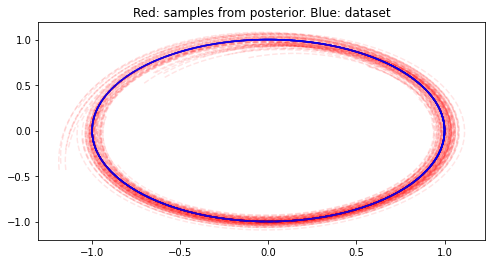

In [488]:
pred_x, qz0_mean, qz0_logvar = model(samp_traj, torch.linspace(0, 5, 100))
pred_x = pred_x.transpose(0, 1)
pred_x = pred_x.detach().cpu()

plt.figure(figsize=(8, 4))
for i in range(100):
    plt.plot(pred_x[i,:,0], pred_x[i,:,1], c='r', alpha=0.1, linestyle ='--')

    # base data
    a = samp_traj.detach().cpu()
    plt.plot(a[:,i,0], a[:,i,1], c='b', alpha=0.1, linestyle ='--')
plt.title('Red: samples from posterior. Blue: dataset')